## Task 1

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib.pyplot import hist

from bs4 import BeautifulSoup
import re

import yaml
import math
from math import asin, acos, sin, cos

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations'
headers = {"User-Agent":"Mozilla/5.0"}
req = urllib.request.Request(url, None, headers)
fp = urllib.request.urlopen(req)

text = fp.read()
text = text.decode("utf8")

fp.close()

In [3]:
soup = BeautifulSoup(text, 'html.parser')

table = soup.find("table", class_="wikitable sortable").tbody
table = table.find_all("tr")
table = table[1:]

In [4]:
def get_name(cur_transfer):
    res = {}
    
    cur_transfer = re.findall('(\d+\w*) (.*)', cur_transfer)
    cur_transfer = cur_transfer[0]
    cur_line = cur_transfer[0]
    res['line'] = cur_line
    
    cur_name = cur_transfer[1].split('at ')
    res['name'] = cur_name[1].split(' via')[0].split(')')[0]
    
    if (cur_line == '4A') or (cur_line == '11A'):
        return None
    return res

In [5]:
def get_data(station_data):
    res = {}
    res['connects'] = []
    tags = station_data.find_all("td")
    
    name = tags[0].get_text('|')
    res['name'] = name.split('|')[0]
    title = station_data.th.a["title"]
    line = re.findall('(\d+\w*)', title)
    line = line[0]
    res['line'] = line
    
    
    opened = tags[3].get_text()
    opened = opened.replace("\n", "")
    res['opened'] = opened
    
    coords = tags[len(tags)-1]
    coords = coords.span.a.find(class_='vcard').find(class_='geo').get_text()
    coords = coords.split('; ')
    latitude = float(coords[0])
    longtitude = float(coords[1])
    res['latitude'] = latitude
    res['longtitude'] = longtitude

    transfers = []
    for transfer in tags[2].find_all('span'):
        span = transfer.span
        if span:
            transfer = get_name(span['title'])
            if transfer:
                transfers.append(transfer)
    res['transfers'] = transfers
    if (line == '4A') or (line == '11A'):
        return None
    
    return res

In [6]:
stations = []

cnt = 0
cnt_brown = 0

cnt_blue = 0
cnt_red = 0
for i in range(len(table)):
    station = get_data(table[i])
    if station:
        stations.append(station)
        
        if cnt > 0:
            if stations[cnt]['line'] == '5': # чтобы закольцевать коричневую ветку
                cnt_brown +=1
            
            if stations[cnt]['line'] == '11':
                cnt_blue +=1
            
            if stations[cnt]['line'] == '14':
                cnt_red +=1
                
            if (stations[cnt]['line'] == stations[cnt - 1]['line']):
                stations[cnt]['connects'].append(stations[cnt - 1]['name'])
                stations[cnt - 1]['connects'].append(stations[cnt]['name'])
                
            if (stations[cnt]['line'] != '5') and (stations[cnt - 1]['line'] == '5'): #закольцевали коричневую
                stations[cnt-1]['transfers'].append({'line': stations[cnt-cnt_brown]['line'], 'name': stations[cnt-cnt_brown]['name']})
                stations[cnt-cnt_brown]['transfers'].append({'line': stations[cnt-1]['line'], 'name': stations[cnt-1]['name']})
            
            if (stations[cnt]['line'] != '11') and (stations[cnt - 1]['line'] == '11'): #закольцевали БЛК
                stations[cnt-1]['transfers'].append({'line': stations[cnt-cnt_blue]['line'], 'name': stations[cnt-cnt_blue]['name']})
                stations[cnt-cnt_blue]['transfers'].append({'line': stations[cnt-1]['line'], 'name': stations[cnt-1]['name']})
                
            if (stations[cnt]['line'] != '14') and (stations[cnt - 1]['line'] == '14'): #закольцевали МЦК
                stations[cnt-1]['transfers'].append({'line': stations[cnt-cnt_red]['line'], 'name': stations[cnt-cnt_red]['name']})
                stations[cnt-cnt_red]['transfers'].append({'line': stations[cnt-1]['line'], 'name': stations[cnt-1]['name']})
        cnt += 1

In [7]:
with open(r'StationsData.yaml', 'w') as file:
    documents = yaml.dump(stations, file)

## Task 2

In [8]:
with open("config.txt", 'r') as file:
    lines = file.readlines()
    V = float(lines[0].split('= ')[1])
    t_transfer = float(lines[1].split('= ')[1])
    t_stay = float(lines[2].split('= ')[1])
    transfers_file = lines[3].split('= ')[1]
    transfers_file = transfers_file.replace('\n', '')

In [9]:
def get_time(v, t_st, longtitude1, latitude1, longtitude2, latitude2):
    R = 6371  
    latitude1, longtitude1, latitude2, longtitude2 = map(math.radians, [latitude1, longtitude1, latitude2, longtitude2])
    dist_lat = latitude2 - latitude1
    dist_lon = longtitude2 - longtitude1
    a = math.sin(dist_lat/2)**2 + math.cos(latitude1)*math.cos(latitude2)*math.sin(dist_lon/2)**2
    c = 2*math.asin(math.sqrt(a))
    return R*c/v+t_st

In [10]:
specified_transfer_times = {}
with open(transfers_file) as file:    
    lines = file.readlines()
    for line in lines:
        curr_transf = line.split('; ')
        time = float(curr_transf[2])
        first_line = curr_transf[0]
        second_line = curr_transf[1]
        specified_transfer_times[(first_line, second_line)] = time
        specified_transfer_times[(second_line, first_line)] = time

In [11]:
stations = []
with open(r'StationsData.yaml') as file:    
    stations = yaml.safe_load(file)

In [12]:
stations_cnt = 0
station_nums = {}
station_names = {}

for station in stations:
    name = station['name'] + ', ' + station['line']
    stations_cnt += 1
    station_nums[name] = stations_cnt
    station_names[stations_cnt] = name

edges = []

for i in range(stations_cnt):
    station = stations[i]
    first_name = station['name'] + ', ' + station['line']
    line = station['line']
    
    for second_station in station['transfers']:
        second_name = second_station['name'] + ', ' + second_station['line']
        if (first_name, second_name) in specified_transfer_times:
            edges.append((first_name, second_name, specified_transfer_times[(first_name, second_name)]))
        else:
            edges.append((first_name, second_name, t_transfer))
    
    if i and line == stations[i - 1]['line']:
        second_name = stations[i - 1]['name'] + ', ' + stations[i - 1]['line']
        longtitude1, latitude1 = station['longtitude'], station['latitude']
        longtitude2, latitude2 = stations[i - 1]['longtitude'], stations[i - 1]['latitude']
        edges.append((first_name, second_name, 
                      get_time(V, t_stay, longtitude1, latitude1, longtitude2, latitude2)))
    
    if i < stations_cnt - 1 and line == stations[i + 1]['line']:
        second_name = stations[i + 1]['name'] + ', ' + stations[i + 1]['line']
        longtitude1, latitude1 = station['longtitude'], station['latitude']
        longtitude2, latitude2 = stations[i + 1]['longtitude'], stations[i + 1]['latitude']
        edges.append((first_name, second_name, 
                      get_time(V, t_stay, longtitude1, latitude1, longtitude2, latitude2)))

In [13]:
with open("SubwayMap.tgf", "w") as fp:
    for station in station_nums:
        fp.write(str(station_nums[station]) + " \"" + str(station) + "\"" + "\n")
    
    fp.write("#\n")
    
    for edge in edges:
        fp.write(str(station_nums[edge[0]]) + " " + str(station_nums[edge[1]]) + " " + str(edge[2]) + "\n")

## Task 3

In [14]:
lines = []
with open("SubwayMap.tgf", "r") as file:
    lines = file.readlines()

In [15]:
N = lines.index('#\n') # узнали количество станций
W = np.ones((N, N)) * np.inf # делаем матрицу с inf для обратного отсчета 

for i in range(N + 1, len(lines)):
    edge = lines[i].split()
    W[int(edge[0]) - 1][int(edge[1]) - 1] = float(edge[2])

for i in range(N):
    W[i][i] = 0

In [16]:
print(N)

282


In [17]:
for k in range(N):
    print(k)
    for i in range(N):
        for j in range(N):
            W[i][j] = min(W[i][j], W[i][k] + W[k][j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
W.mean() 

24.286680906429694

In [19]:
mean_time = W.mean(axis = 1) 

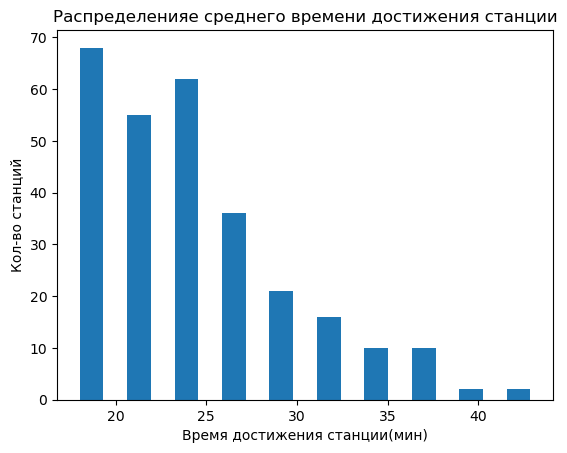

In [20]:
hist(mean_time, rwidth=0.5)
plt.pyplot.xlabel('Время достижения станции(мин)')
plt.pyplot.ylabel('Кол-во станций')
plt.pyplot.title('Распределенияе среднего времени достижения станции')
axes = plt.pyplot.gca()
plt.pyplot.show()

## Task 4

In [21]:
saved_line = lines

In [22]:
saved_N = N

In [23]:
line_num = '10' #салатовая ветка

In [24]:
lines = []
ids = []
stations = []
edges = []
with open("SubwayMap.tgf", "r") as file:
    lines = file.readlines()

for i in range(N):
    cur_num = lines[i].split('"')[1].split(',')[1].strip() # получаем номер линии 
    if cur_num != line_num:
        ids.append(lines[i].split()[0])
        
for i in range(N):
    cur_num = lines[i]
    if cur_num != line_num:
        stations.append(lines[i])
        
edges = [lines[i] for i in range(N+1, len(lines)) 
             if lines[i].split()[0] in ids
             and lines[i].split()[1] in ids]
N = len(ids)

In [25]:
indexes_dict = {int(ids[i]):i for i in range(N)}
W = np.ones((N, N))*np.inf

In [26]:
for i in range(len(edges)):
    edge = edges[i].split()
    W[indexes_dict[int(edge[0])]][indexes_dict[int(edge[1])]] = float(edge[2])

for i in range(N):
    W[i][i] = 0

In [27]:
for k in range(N):
    print(k)
    for i in range(N):
        for j in range(N):
            W[i,j] = min(W[i,j], W[i,k] + W[k,j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258


In [28]:
mean_time = W.mean(axis = 1) 

In [29]:
old_dict = {line.split('"')[1]:int(line.split('"')[0].strip()) for line in saved_line[:saved_N]}

In [30]:
new_dict = {stations[i]:indexes_dict[int(ids[i])] for i in range(N)}

In [31]:
vals= {stations[i]:mean_time[i] for i in range(N)}

In [32]:
vals

{'1 "Bulvar Rokossovskogo, 1"\n': 26.937985928843585,
 '2 "Cherkizovskaya, 1"\n': 25.63880453211808,
 '3 "Preobrazhenskaya Ploshchad, 1"\n': 24.811793004077003,
 '4 "Sokolniki, 1"\n': 23.652939138470455,
 '5 "Krasnoselskaya, 1"\n': 22.266513166538758,
 '6 "Komsomolskaya, 1"\n': 20.604957396588105,
 '7 "Krasnye Vorota, 1"\n': 20.841751800364793,
 '8 "Chistye Prudy, 1"\n': 19.590965622601704,
 '9 "Lubyanka, 1"\n': 18.472213886164745,
 '10 "Okhotny Ryad, 1"\n': 17.75853909276323,
 '11 "Biblioteka Imeni Lenina, 1"\n': 17.94778611573736,
 '12 "Kropotkinskaya, 1"\n': 19.18051100061754,
 '13 "Park Kultury, 1"\n': 19.35885052866663,
 '14 "Frunzenskaya, 1"\n': 20.070658725285526,
 '15 "Sportivnaya, 1"\n': 20.151119062513388,
 '16 "Vorobyovy Gory, 1"\n': 21.564214862700894,
 '17 "Universitet, 1"\n': 22.613155553165015,
 '18 "Prospekt Vernadskogo, 1"\n': 23.326289438466883,
 '19 "Yugo-Zapadnaya, 1"\n': 25.24989318150242,
 '20 "Troparyovo, 1"\n': 27.1900518460352,
 '21 "Rumyantsevo, 1"\n': 29.1531

In [34]:
mean_time[int(ids[0])]

25.63880453211808